In [1]:
%load_ext watermark
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from myst_nb import glue
from slugify import slugify

from plastockconf import name_zones, name_frequentation, name_situation
from plastockconf import name_substrate, name_distance, table_css_styles

from plastock import add_table_to_page, capitalize_x_tick_labels, capitalize_x_and_y_axis_labels, capitalize_legend_components, attribute_summary

def translate_describe(x, value_column):
    described = x.to_dict()
    described.pop("count")
    described["moyenne"] = described.pop("mean")
    described["écart-type"] = described.pop("std")
    df = pd.DataFrame(described.items())
    df.set_index(0, inplace=True)
    df.rename(columns={1:value_column}, inplace=True)
    df.index.name = None
    
    
    return df
format_kwargs = dict(precision=2, thousands="'", decimal=",")

def select_a_set_of_values(data, column_one, threshold_data):
    
    return data.loc[data[column_one] > threshold_data]

glue('blank_caption', " ", display=False)

new_data = pd.read_csv("data/end_pipe/macro_current.csv")
beach_data = pd.read_csv("data/end_pipe/pstock_beaches_current.csv")

In [2]:
new_column_names = {
    "Position":"position",
    "Substrat":"substrat",
    "Date":"date",
    "Code":"code",
    "Quantité":"quantité",
    "Aire":"area"
}

work_data = new_data[["Plage", *new_column_names.keys()]].copy()
work_data.rename(columns=new_column_names, inplace=True)
work_data["slug"] = work_data.Plage.apply(lambda x: slugify(x))
work_data["échantillon"] = list(zip(work_data.slug, work_data['date']))
work_data['date'] = pd.to_datetime(work_data["date"], format="mixed", dayfirst=True)
work_data.dropna(inplace=True)
work_data[["position", "substrat"]] = work_data[["position", "substrat"]].astype("int")
work_data["échantillon"] = work_data["échantillon"].astype(str)


event_total = work_data.groupby(["échantillon", "Plage", "date", "position", "area"], as_index=False)["quantité"].sum()
event_total['pcs/m²'] = event_total["quantité"]/event_total.area


# etas = work_data.drop_duplicates(["échantillon", "area"])
# etas = etas.groupby("échantillon").area.sum()
# etac = work_data.groupby(["échantillon", "Plage", "date", "position", "area"], as_index=False)["quantité"].sum()
# etac['area'] = etac["échantillon"].apply(lambda x: etas.loc[str(x)])
# etac["t"] = etac["quantité"]/etac.area
# ti = etac.groupby("échantillon").t.sum()

(macro_summary)=
# Macro déchets plage et position

__Résultats agrégés par objet, position et échantillon__

In [3]:
caption = "Les données sont regroupées en deux groupes par échantillon: ligne-d'eau, plage-seche, tous objéts compris."

columns=["Plage", "position", "code", "quantité", "échantillon"]

table_one = work_data[columns][work_data['échantillon'] == "('amphion', '01.02.2022')"].head()
table_one.set_index('code', drop=True, inplace=True)
table_one.index.name = None
t_one = table_one.style.set_table_styles(table_css_styles)

table_no = 1
section = 'A'
page = 3

table_one = add_table_to_page(t_one, table_no, caption, section, page, " ")
glue('a3tablone', table_one, display=True)

,Plage,Position,Quantité,Échantillon
G24,Amphion,1,2,"('amphion', '01.02.2022')"
G24,Amphion,2,42,"('amphion', '01.02.2022')"
G66,Amphion,2,7,"('amphion', '01.02.2022')"
G131,Amphion,2,1,"('amphion', '01.02.2022')"
G31,Amphion,1,2,"('amphion', '01.02.2022')"


## Nombre cumulé d'échantillons et particules par plage

In [4]:
sample_totals = event_total.groupby(["échantillon", "date", "Plage", "position"], as_index=False)["pcs/m²"].sum()
df2 = sample_totals.copy()
value_column = "moyenne"

sample_averages = df2.groupby("Plage", as_index=False).agg({"échantillon": "nunique", "pcs/m²":"mean"})
average_of_sample_totals = df2["pcs/m²"].mean()
sample_averages.rename(columns={"pcs/m²":value_column}, inplace=True)
sample_averages.set_index("Plage", inplace=True, drop=True)
sample_averages.index.name = None

In [5]:
location_summary = work_data.groupby("Plage", as_index=False).agg({"échantillon": "nunique", "quantité":"sum"})
location_summary["% échantillon "] = location_summary['échantillon']/location_summary['échantillon'].sum()
location_summary["%  quantité"] = location_summary["quantité"]/location_summary["quantité"].sum()

df1 = location_summary.copy()
df1.set_index("Plage", inplace=True, drop=True)
df1.index.name = None
a_property =  {'color' : 'red'}
a_property2 = { 'color': 'dodgerblue'}

select_values = df1["% échantillon "] < df1["%  quantité"]
test_one = df1.loc[select_values].index

caption1 = "Nombre cumulé d'échantillons et le total par plage."
caption2 = "Les plages où le proportion du comptage est supérieur au proportion des échantillons sont en rouge. Les plages dont la moyenne des résultats est supérieure à la moyenne du projet sont en BLEU."  
caption = f'{caption1} {caption2}'

df1["moyenne"] = df1.index.map(lambda x: sample_averages['moyenne'].loc[x])
select_values2 = df1["moyenne"] > 1.45
test_two = df1[select_values2].index

ttwo = df1.style.set_table_styles(table_css_styles).set_properties(subset=pd.IndexSlice[test_two, ["moyenne"]], **a_property2)
ttwo = ttwo.set_properties(subset = pd.IndexSlice[test_one,["% échantillon ", "%  quantité"]], **a_property)

table_no += 1

table_two = add_table_to_page(ttwo, table_no, caption, section, page, " ")
glue('a3tabletwo', table_two, display=True)

,Échantillon,Quantité,% échantillon,% quantité,Moyenne
Amphion,4,2'459,"0,04","0,09","1,28"
Anthy,4,149,"0,04","0,01","0,16"
Aubonne,4,193,"0,04","0,01","0,17"
Baby plage,4,1'179,"0,04","0,04","0,53"
Bouveret,4,3'286,"0,04","0,12","2,39"
Clarens,4,1'128,"0,04","0,04","0,92"
Crans,3,21,"0,03","0,00","0,44"
Cully,4,48,"0,04","0,00","0,17"
Excenevex,4,3'931,"0,04","0,14","1,26"
Gland,4,206,"0,04","0,01","1,16"


In [6]:
bar_plots = pd.melt(location_summary, id_vars="Plage", value_vars=["% échantillon ", "%  quantité"])
fig, ax = plt.subplots()
sns.barplot(data=bar_plots, x="Plage", y="value", hue="variable", ax=ax)
ax.legend(loc="upper left")
ax.tick_params(axis="x", labelrotation=90, labelright=True, labelsize=12 )
ax.set_ylabel('% du total')
ax.set_xlabel(" ")
glue('fig-A31', fig, display=False)
plt.close()

```{glue:figure} fig-A31
---
name: fig-A31
---
{glue:text}`blank_caption` 
```

In [7]:
attribute_columns = ["Plage", "position", "substrat"]
percent_of_samples = df1.loc[select_values]['échantillon'].sum()/location_summary['échantillon'].sum()
attributes_of_samples = work_data[work_data.Plage.isin(test_one)].drop_duplicates(["Plage"])

attribute_keys = [name_zones, name_substrate, name_frequentation, name_situation, name_distance]

## Compte moyen par échantillon et plage

In [8]:
# bpt = event_total.groupby(["échantillon", "date", "Plage", "position"], as_index=False).agg({'area': 'sum', 'quantité':'sum'})
# bpx = bpt.groupby(["échantillon"], as_index=False).agg({'quantité':'sum', 'area':'sum'})
# bpx['pcs/m²']= bpx["quantité"]/bpx.area
# df2 = bpx.copy()
value_column = "moyenne"

summary_particuless = event_total["pcs/m²"].describe()

t_three =  translate_describe(summary_particuless, "pcs/m²").T.style.set_table_styles(table_css_styles)

table_no += 1
caption = 'Le résumé des résultats du nombre de déchets trouvées par m² par position.'

table_three = add_table_to_page(t_three, table_no, caption, section, page, " ")
glue('a3table3', table_three, display=True)

,Min,25%,50%,75%,Max,Moyenne,Écart-type
Pcs/m²,"0,01","0,18","0,38","0,97","7,60","0,77","1,04"


In [9]:
fig, ax = plt.subplots(2,2, figsize=(7,7))

sns.scatterplot(data=sample_totals, x="date", y="pcs/m²", ax=ax[0,0])
ax[0,0].tick_params(labelbottom=False, bottom=False)
ax[0,0].set_title("Total par échantillon", loc="left")
capitalize_x_and_y_axis_labels(ax[0,0])

sns.boxplot(data=sample_totals, y="pcs/m²", dodge=False, width=.9, ax=ax[0,1])
ax[0,1].set_title("Boîte de Tukey", loc="left")
capitalize_x_and_y_axis_labels(ax[0,1])

sns.histplot(data=sample_totals, x="pcs/m²", ax=ax[1,0], stat="probability", kde=True)
ax[1,0].yaxis.set_major_formatter('{x:.2f}')
ax[1,0].set_ylabel("Probabilité")
ax[1,0].set_title("Histogramme", loc="left")
capitalize_x_and_y_axis_labels(ax[1,0])

sns.ecdfplot(data=sample_totals, x="pcs/m²", ax=ax[1,1])
ax[1,1].set_title("Fonction de répartition", loc="left")
capitalize_x_and_y_axis_labels(ax[1,1])
plt.tight_layout()

glue('fig-A32', fig, display=False)
plt.close()

```{glue:figure} fig-A32
---
name: fig-A32
---
{glue:text}`blank_caption` 
```

## Comptes moyenne par position 

In [10]:
position_totals = event_total.groupby(["échantillon","date", "Plage", "position"], as_index=False).agg({'area': 'sum', 'quantité':'sum'})
position_totals["position"] = position_totals.position.apply(lambda x: name_zones[x])
position_totals['pcs/m²'] = position_totals['quantité']/position_totals.area
position_totals["position"] = position_totals["position"].apply(lambda x: x.capitalize())

column_display = {
    "count":"échantillons",
    "mean": "moyenne",
    "std": "écart type",
    "échantillon":"échantillon"
}

voi = "position"
vals = "pcs/m²"
groupbys = ['échantillon', voi]
labels = name_zones
position_summary = attribute_summary(event_total, vals, voi, columns=column_display, labels=name_zones, as_type='float')

table_no += 1
caption = "Le résumé des totaux d'échantillons par position sur la plage."

table_five = add_table_to_page(position_summary, table_no, caption, section, page, " ")
glue('table-five', table_five, display=True)

,Échantillons,Moyenne,Écart type,Min,25%,50%,75%,Max
Ligne d'eau,95,"0,84","1,26","0,02","0,18","0,38","0,91","7,60"
Plage seche,88,"0,70","0,74","0,01","0,18","0,40","1,08","3,07"


In [11]:
fig, ax = plt.subplots(2,2, figsize=(7,7))

sns.scatterplot(data=position_totals, x="date", y="pcs/m²", hue="position", ax=ax[0,0])
ax[0,0].tick_params(labelbottom=False, bottom=False)
ax[0,0].set_title("Total par échantillon", loc="left")
capitalize_x_and_y_axis_labels(ax[0,0])
sns.move_legend(ax[0, 0], title=" ", loc='best')

sns.boxplot(data=position_totals, x="position", y="pcs/m²", hue="position", dodge=False, width=.9, ax=ax[0,1])
ax[0,1].set_title("Boîte de Tukey", loc="left")
ax[0,1].set_xlabel("")
# ax[0,1].legend().remove()
capitalize_x_tick_labels(ax[0,1])
capitalize_x_and_y_axis_labels(ax[0,1])

sns.histplot(data=position_totals, x="pcs/m²", hue="position", ax=ax[1,0], multiple="stack", stat="probability", kde=True)
ax[1,0].yaxis.set_major_formatter('{x:.2f}')
ax[1,0].set_ylabel("Probabilité")
ax[1,0].set_title("Histogramme", loc="left")
ax[1,0].get_legend().remove()
capitalize_x_and_y_axis_labels(ax[1,0])

sns.ecdfplot(data=position_totals, x="pcs/m²", hue="position", ax=ax[1,1])
ax[1,1].set_title("Fonction de répartition", loc="left")
capitalize_x_and_y_axis_labels(ax[1,1])
sns.move_legend(ax[1, 1], title=" ", loc='best')

plt.tight_layout()

glue('fig-A33', fig, display=False)
plt.close()

```{glue:figure} fig-A33
---
name: fig-A33
---
{glue:text}`blank_caption` 
```

In [12]:
t = position_totals.groupby(['Plage', 'position'], as_index=False)['pcs/m²'].mean()
t = t.pivot(index="Plage", columns="position")
t.index.name = None
t.columns.name = None
sax = t.style.set_table_styles(table_css_styles)


position_columns = list(name_zones.values())

args = [("pcs/m²", "Ligne d'eau"), ("pcs/m²", "Plage seche")]

water_line = select_a_set_of_values(t, args[0], average_of_sample_totals).index
plage_seche = select_a_set_of_values(t, args[1], average_of_sample_totals).index

caption = "Le résultat moyen de pcs/m² par position."
 
sax = sax.set_properties(subset = pd.IndexSlice[water_line,args[0]], **a_property)
sax = sax.set_properties(subset = pd.IndexSlice[plage_seche,args[1]], **a_property)
table_no += 1
sax = add_table_to_page(sax,table_no, caption, section, page, rule=" ")
glue('table-six', sax, display=True)

### Distributions



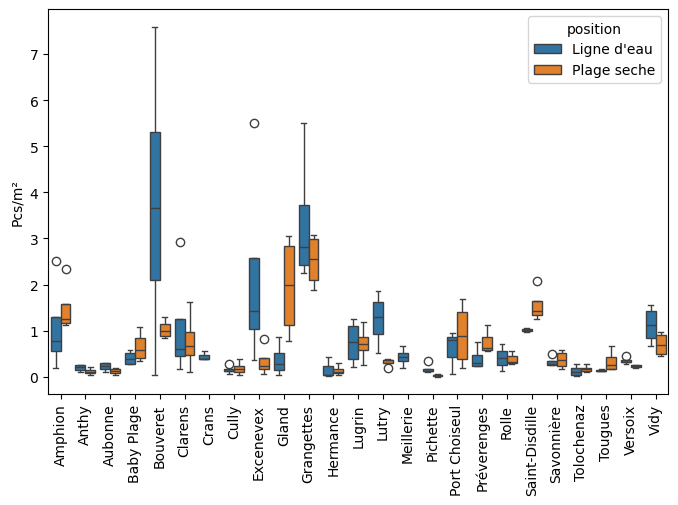

In [13]:
fig, ax = plt.subplots(1, figsize=(8,5))

sns.boxplot(data=position_totals, x="Plage", y="pcs/m²", hue="position", ax=ax)

ax.tick_params(axis="x", labelrotation=90)
ax.set_xlabel("")
capitalize_x_and_y_axis_labels(ax)

plt.show()

In [14]:
%watermark --iversions -b -r

Git repo: https://github.com/hammerdirt-analyst/plastock.git

Git branch: feb5

seaborn   : 0.13.1
pandas    : 2.0.3
matplotlib: 3.8.2
numpy     : 1.26.3

